In [2]:
import json
import pandas as pd
from nltk.tokenize import sent_tokenize
from tqdm.auto import tqdm
from string import punctuation
full_punctuation = punctuation + "–" + "," + "»" + "«" + "…" +'’'

In [2]:
with open("train-v2.0.json", "r") as f:
    data = json.load(f)

In [7]:
len(data['data'])

442

In [10]:
data['data'][0]['paragraphs'][0]

{'qas': [{'question': 'When did Beyonce start becoming popular?',
   'id': '56be85543aeaaa14008c9063',
   'answers': [{'text': 'in the late 1990s', 'answer_start': 269}],
   'is_impossible': False},
  {'question': 'What areas did Beyonce compete in when she was growing up?',
   'id': '56be85543aeaaa14008c9065',
   'answers': [{'text': 'singing and dancing', 'answer_start': 207}],
   'is_impossible': False},
  {'question': "When did Beyonce leave Destiny's Child and become a solo singer?",
   'id': '56be85543aeaaa14008c9066',
   'answers': [{'text': '2003', 'answer_start': 526}],
   'is_impossible': False},
  {'question': 'In what city and state did Beyonce  grow up? ',
   'id': '56bf6b0f3aeaaa14008c9601',
   'answers': [{'text': 'Houston, Texas', 'answer_start': 166}],
   'is_impossible': False},
  {'question': 'In which decade did Beyonce become famous?',
   'id': '56bf6b0f3aeaaa14008c9602',
   'answers': [{'text': 'late 1990s', 'answer_start': 276}],
   'is_impossible': False},
  {'q

In [12]:
data['data'][0]['paragraphs'][0]['context'][505:]

'Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'

In [13]:
len(data['data'])

442

In [66]:
def get_partial_inclusion(answer, sentence):
    answer_tokens = answer.split()
    clean_tokens = []
    for token in answer_tokens:
        clean_token = ''
        for char in token:
            if char not in full_punctuation:
                clean_token += char
        clean_tokens.append(clean_token)
    for orig_ans_token in answer_tokens:
        if orig_ans_token in sentence:
            return True
    for clean_ans_token in answer_tokens:
        if clean_ans_token in sentence:
            return True
    return False

In [94]:
def get_answer_sentence(answer, whole_text, start_from_index):
    clean_answers = ''
    for answer_char in answer:
        if answer_char not in full_punctuation:
            clean_answers += answer_char
    sentences_list = sent_tokenize(whole_text)
    for sentence in sentences_list:
#         part_incl = get_partial_inclusion(answer,sentence)
#             print("current_sentence", sentence, "answer",answer)
        if answer in sentence or clean_answers in sentence:# or part_incl == True:
            return sentence
#         else:
#             print("text", whole_text)
#             print("sentence", sentence)
#             print("answer", answer)
#             #raise "correct_index_but_no_phrase"
#     print("text", whole_text)
#     print("answer", answer)
#     raise "correct_index_but_no_phrase"
    return None

def get_answer_sentence_with_ctx(answer, whole_text, start_from_index):
    clean_answers = ''
    for answer_char in answer:
        if answer_char not in full_punctuation:
            clean_answers += answer_char
    sentences_list = sent_tokenize(whole_text)
    for sentence_index in range(len(sentences_list)):
        part_incl = get_partial_inclusion(answer,sentences_list[sentence_index])
        if answer in sentences_list[sentence_index] or clean_answers in sentences_list[sentence_index]:# or part_incl == True:
            if sentence_index - 1 < 0:
                prev_sent = ''
            else:
                prev_sent = sentences_list[sentence_index-1]
            if sentence_index + 1 >= len(sentences_list):
                next_sent = ''
            else:
                next_sent = sentences_list[sentence_index+1]
            return {"prev_st":prev_sent,"ans_st":sentences_list[sentence_index],
                   "next_st":next_sent}
#         else:
#             print("text", whole_text)
#             print("sentence", sentences_list[sentence_index])
#             print("answer", answer)
#             #raise "correct_index_but_no_phrase"
#     print("text", whole_text)
#     print("answer", answer)
#     raise "correct_index_but_no_phrase"
    return None
    

In [95]:
question_list = []
asnwer_word_list = []
answers_starts_list = []
is_impossible_list = []
whole_paragraph_list = []
answer_sentence_list = []
three_sentences_list = []
empty_sent = 0
empty_ctx = 0
for text in tqdm(data['data']):
    for paragraph in text['paragraphs']:
#         print(paragraph)
        for qas in paragraph['qas']:
            for answer in qas['answers']:
                question_list.append(qas['question'])
                asnwer_word_list.append(answer['text'])
                answers_starts_list.append(answer['answer_start'])
                is_impossible_list.append(qas['is_impossible'])
                whole_paragraph_list.append(paragraph['context'])
                ans_sentence = get_answer_sentence(answer['text'], paragraph['context'], answer['answer_start'])
                if ans_sentence == None: empty_sent += 1
                answer_sentence_list.append(ans_sentence)
                ans_sentence_with_ctx = get_answer_sentence_with_ctx(answer['text'], paragraph['context'], answer['answer_start'])
                if ans_sentence_with_ctx == None: empty_ctx += 1
                three_sentences_list.append(ans_sentence_with_ctx)
#         print()
#     break
print("empty_sent",empty_sent, "empty_ctx",empty_ctx)
df = pd.DataFrame()
df = pd.DataFrame(list(zip(question_list, asnwer_word_list,answers_starts_list, is_impossible_list, 
                           whole_paragraph_list,answer_sentence_list,three_sentences_list)), 
               columns =['question', 'answer', 'answer_index', 'impossible_answer','whole_paragraph',
                         "answer_sent","answer_ctx"]) 
# df.head()


empty_sent 211 empty_ctx 211


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86821 entries, 0 to 86820
Data columns (total 7 columns):
question             86821 non-null object
answer               86821 non-null object
answer_index         86821 non-null int64
impossible_answer    86821 non-null bool
whole_paragraph      86821 non-null object
answer_sent          86610 non-null object
answer_ctx           86610 non-null object
dtypes: bool(1), int64(1), object(5)
memory usage: 4.1+ MB


In [104]:
df['answer_ctx'].iloc[34]

{'prev_st': 'On stage, her dynamic, highly choreographed performances have led to critics hailing her as one of the best entertainers in contemporary popular music.',
 'ans_st': "Throughout a career spanning 19 years, she has sold over 118 million records as a solo artist, and a further 60 million with Destiny's Child, making her one of the best-selling music artists of all time.",
 'next_st': "She has won 20 Grammy Awards and is the most nominated woman in the award's history."}

In [105]:
df.to_csv("dataset.csv")

In [97]:
df.head(40)

,question,answer,answer_index,impossible_answer,whole_paragraph,answer_sent,answer_ctx
0,When did Beyonce start becoming popular?,in the late 1990s,269,False,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"Born and raised in Houston, Texas, she perform...",{'prev_st': 'Beyoncé Giselle Knowles-Carter (/...
1,What areas did Beyonce compete in when she was...,singing and dancing,207,False,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"Born and raised in Houston, Texas, she perform...",{'prev_st': 'Beyoncé Giselle Knowles-Carter (/...
2,When did Beyonce leave Destiny's Child and bec...,2003,526,False,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,Their hiatus saw the release of Beyoncé's debu...,"{'prev_st': 'Managed by her father, Mathew Kno..."
3,In what city and state did Beyonce grow up?,"Houston, Texas",166,False,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"Born and raised in Houston, Texas, she perform...",{'prev_st': 'Beyoncé Giselle Knowles-Carter (/...
4,In which decade did Beyonce become famous?,late 1990s,276,False,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"Born and raised in Houston, Texas, she perform...",{'prev_st': 'Beyoncé Giselle Knowles-Carter (/...
5,In what R&B group was she the lead singer?,Destiny's Child,320,False,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"Born and raised in Houston, Texas, she perform...",{'prev_st': 'Beyoncé Giselle Knowles-Carter (/...
6,What album made her a worldwide known artist?,Dangerously in Love,505,False,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,Their hiatus saw the release of Beyoncé's debu...,"{'prev_st': 'Managed by her father, Mathew Kno..."
7,Who managed the Destiny's Child group?,Mathew Knowles,360,False,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"Managed by her father, Mathew Knowles, the gro...","{'prev_st': 'Born and raised in Houston, Texas..."
8,When did Beyoncé rise to fame?,late 1990s,276,False,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"Born and raised in Houston, Texas, she perform...",{'prev_st': 'Beyoncé Giselle Knowles-Carter (/...
9,What role did Beyoncé have in Destiny's Child?,lead singer,290,False,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"Born and raised in Houston, Texas, she perform...",{'prev_st': 'Beyoncé Giselle Knowles-Carter (/...


In [ ]:
+74957829778
91

In [3]:
df = pd.read_csv("dataset.csv")

In [10]:
sent_len = []
ex_cnt = 0
for sent in list(df['question']):
#     print(sent)
#     print(len(sent.split(' ')))
    try:
        sent_len.append(len(sent.split(' ')))
    except:
        ex_cnt += 1
        continue
for sent in list(df['answer_sent']):
#     print(sent)
#     print(len(sent.split(' ')))
    try:
        sent_len.append(len(sent.split(' ')))
    except:
        ex_cnt += 1
        continue
print(ex_cnt)
    

211


In [13]:
import seaborn as sns


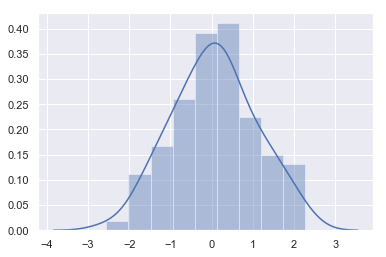

In [16]:
import seaborn as sns, numpy as np
sns.set(); np.random.seed(0)
x = np.random.randn(100)
ax = sns.distplot(x)

In [17]:
x

array([ 1.76405235,  0.40015721,  0.97873798,  2.2408932 ,  1.86755799,
       -0.97727788,  0.95008842, -0.15135721, -0.10321885,  0.4105985 ,
        0.14404357,  1.45427351,  0.76103773,  0.12167502,  0.44386323,
        0.33367433,  1.49407907, -0.20515826,  0.3130677 , -0.85409574,
       -2.55298982,  0.6536186 ,  0.8644362 , -0.74216502,  2.26975462,
       -1.45436567,  0.04575852, -0.18718385,  1.53277921,  1.46935877,
        0.15494743,  0.37816252, -0.88778575, -1.98079647, -0.34791215,
        0.15634897,  1.23029068,  1.20237985, -0.38732682, -0.30230275,
       -1.04855297, -1.42001794, -1.70627019,  1.9507754 , -0.50965218,
       -0.4380743 , -1.25279536,  0.77749036, -1.61389785, -0.21274028,
       -0.89546656,  0.3869025 , -0.51080514, -1.18063218, -0.02818223,
        0.42833187,  0.06651722,  0.3024719 , -0.63432209, -0.36274117,
       -0.67246045, -0.35955316, -0.81314628, -1.7262826 ,  0.17742614,
       -0.40178094, -1.63019835,  0.46278226, -0.90729836,  0.05

In [18]:
sent_len_arr = np.array(sent_len)

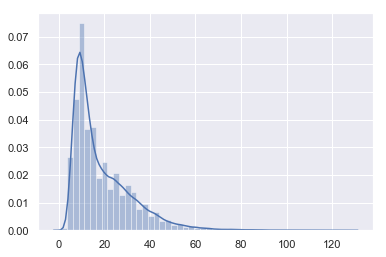

In [21]:
sns.distplot([x for x in sent_len_arr if x <= 128])

In [15]:
sent_len[:10]

[6, 11, 11, 11, 7, 9, 8, 6, 6, 8]

In [11]:
len(sent_len)

173431

In [10]:
exc_count = 0 
norm_lines = 1
with open('sent_to_quest.txt', 'w') as the_file:
    for answer_sent, question in zip(list(df['answer_sent']), list(df['question'])):
        try:
            the_file.write(answer_sent + '\t' + question + '\n')
            norm_lines += 1
        except:
            exc_count += 1
print("exc_count", exc_count, "norm_lines", norm_lines)

exc_count 211 norm_lines 86611


In [4]:
for answer_sent, question in zip(list(df['answer_sent']), list(df['question'])):
    print(answer_sent)
    print(question)
    break

Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child.
When did Beyonce start becoming popular?
